In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /home/tan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset_path = "Data/Twitter_Data.csv"
df = pd.read_csv(dataset_path)

df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
df = df.dropna()

In [4]:
def text_normalize(text):
    # Lowercasing
    text = text.lower()

    # Retweet old acronym "RT" removal
    text = re.sub(r'^rt[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?://.*[\r\n]*', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Stemming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text

In [5]:
vectorizer = TfidfVectorizer ( max_features =2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

In [6]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

In [7]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)

y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] = 1


In [8]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

# Chia dữ liệu thành tập huấn luyện và tập validation
X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

# Chia tập huấn luyện thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)


In [11]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis=1)[:, None]

def compute_loss(y_hat, y):
    n = y.size
    return (-1 / n) * np.sum(y * np.log(y_hat))

def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)
    return y_hat

def compute_gradient(X, y, y_hat):
    n = y.size
    return np.dot(X.T, (y_hat - y)) / n

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()
    return acc


In [9]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))


In [12]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)
        train_acc = compute_accuracy(X_i, y_i, theta)
        train_batch_accs.append(train_acc)

    # Validation
    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)
    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')



EPOCH 1:	Training loss: 0.377	Validation loss: 0.376

EPOCH 2:	Training loss: 0.377	Validation loss: 0.376

EPOCH 3:	Training loss: 0.377	Validation loss: 0.376

EPOCH 4:	Training loss: 0.376	Validation loss: 0.375

EPOCH 5:	Training loss: 0.376	Validation loss: 0.375

EPOCH 6:	Training loss: 0.376	Validation loss: 0.375

EPOCH 7:	Training loss: 0.375	Validation loss: 0.374

EPOCH 8:	Training loss: 0.375	Validation loss: 0.374

EPOCH 9:	Training loss: 0.375	Validation loss: 0.374

EPOCH 10:	Training loss: 0.374	Validation loss: 0.373

EPOCH 11:	Training loss: 0.374	Validation loss: 0.373

EPOCH 12:	Training loss: 0.374	Validation loss: 0.373

EPOCH 13:	Training loss: 0.374	Validation loss: 0.373

EPOCH 14:	Training loss: 0.373	Validation loss: 0.372

EPOCH 15:	Training loss: 0.373	Validation loss: 0.372

EPOCH 16:	Training loss: 0.373	Validation loss: 0.372

EPOCH 17:	Training loss: 0.372	Validation loss: 0.372

EPOCH 18:	Training loss: 0.372	Validation loss: 0.371

EPOCH 19:	Training

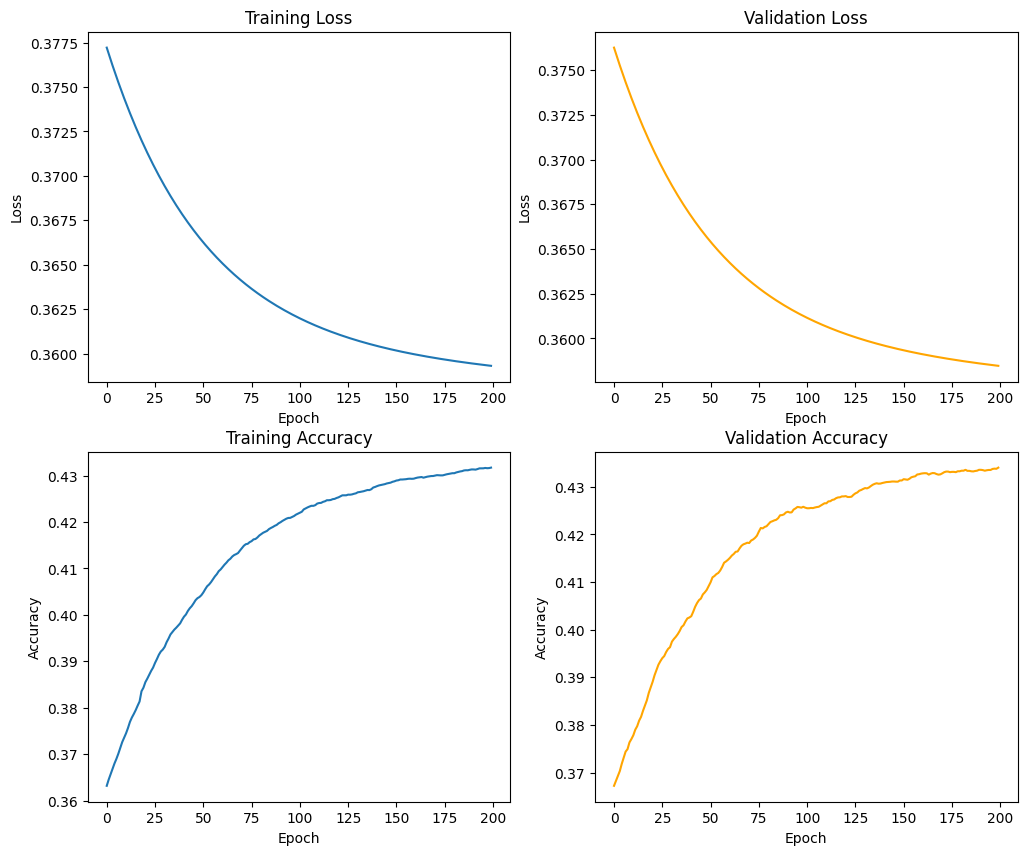

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [14]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print('Evaluation on validation and test set:')
print(f'Validation Set Accuracy: {val_set_acc}')
print(f'Test Set Accuracy: {test_set_acc}')


Evaluation on validation and test set:
Validation Set Accuracy: 0.4340369393139842
Test Set Accuracy: 0.4322881511934712
